In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/CourseMaterial/Supervised Machine Learning/Variational Autoencoder

/content/drive/MyDrive/CourseMaterial/Supervised Machine Learning/Variational Autoencoder


In [5]:
data = pd.read_csv('mnist_train.csv')

In [6]:
data = np.array(data)
data = data[0:10000,:] # Extracting first 10000 samples
data.shape

(10000, 785)

In [7]:
# Data without labels because Unsupervised learning
data = data[:,1:]

# Data Normalization
dataN = data / np.max(data)

# Converting to pytorch tensor
dataT = torch.tensor( dataN, dtype = torch.float32)

# Create Variational Autoencoder Class

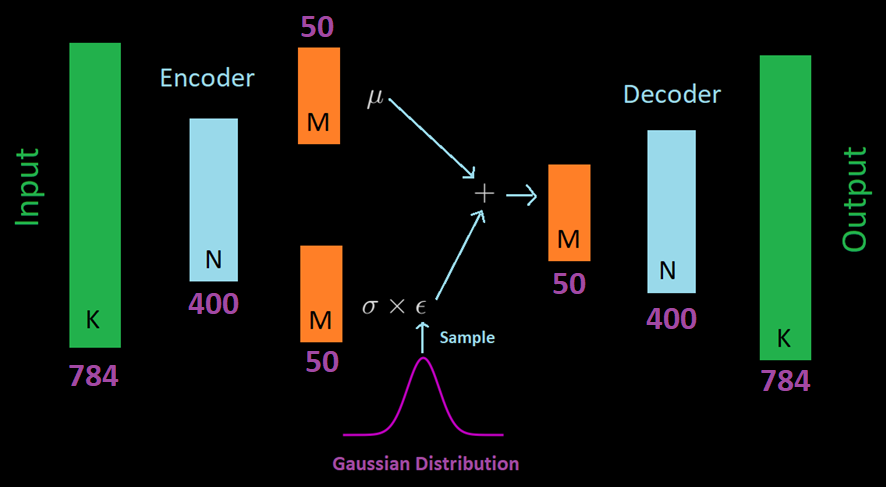

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2_mean = nn.Linear(400, 50) # 50 is the size of latent layer
        self.fc2_logvar = nn.Linear(400, 50)
        self.fc3 = nn.Linear(50, 400)
        self.fc4 = nn.Linear(400, 784)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc2_mean(h)
        log_var = self.fc2_logvar(h) # Here we also pass h because log_var is also related to late hidden layer of encoder.
        return mu, log_var

    def reparameterization(self, mu, logvar):
        std = torch.exp(logvar/2) # Caculating the standard deviation
        eps = torch.randn_like(std) # Sampling from Gaussian Normal distribution with shape equal to stdev ( we use _like)
        z = mu + eps * std
        return z

    def decoder(self, z):  # z = mu + eps *std
        h = F.relu(self.fc3(z))
        out = torch.sigmoid(self.fc4(h)) # sigmoid because we normalize it between zero and one
        return out

    def forward(self, x): # This is the forward function. We combine all the above functions.The function encode is returning
                          # mu and logvar, therefore we start out forward function from mu, logvar.

        mu, logvar = self.encoder(x)
        z = self.reparameterization(mu, logvar)
        predicted = self.decoder(z)
        return predicted, mu, logvar



# Create a loss function

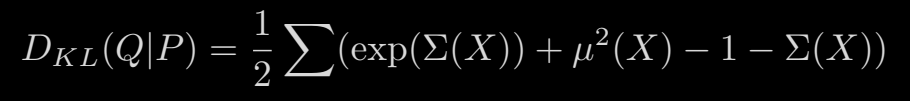

In [9]:
def loss_func(reconstructed_image, original_image, mu, logvar):
    BCE = F.binary_cross_entropy(reconstructed_image, original_image, reduction = 'sum') # BCE Loss for image reconstruction
    DKL = 0.5 * torch.sum(logvar.exp() + mu.pow(2) - 1 - logvar) # kld loss for reduccing similarities b/w distributions.
    return BCE + DKL # sum of all the losses


# We are using BCE loss since our target or original image is normalized between 0 and 1.
# reduction = 'sum' means we want to sum the output loss.

# Check GPU

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Create Model Instance and set optimizer

In [ ]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

In [ ]:
model

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2_mean): Linear(in_features=400, out_features=50, bias=True)
  (fc2_logvar): Linear(in_features=400, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)

# Train the model

In [ ]:
epochs = 21001

losses = torch.zeros(epochs)

for epoch in range(epochs):

  # Selecting a batchsize  of 32.

  random_idx = np.random.choice(dataT.shape[0], size=32)

  X = dataT[random_idx,:].to(device)
  predicted, mu, logvar = model(X)
  loss = loss_func(predicted, X, mu, logvar)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  losses[epoch] = loss.item()

  if (epoch % 1000) == 0:

      print(f' epochs : {epoch}  loss : {loss : 2.2f}')

 epochs : 0  loss :  17466.86
 epochs : 1000  loss :  4106.62
 epochs : 2000  loss :  3675.13
 epochs : 3000  loss :  3493.44
 epochs : 4000  loss :  3476.79
 epochs : 5000  loss :  3573.56
 epochs : 6000  loss :  3228.29
 epochs : 7000  loss :  3377.87
 epochs : 8000  loss :  3565.73
 epochs : 9000  loss :  3298.42
 epochs : 10000  loss :  3121.57
 epochs : 11000  loss :  3412.20
 epochs : 12000  loss :  3163.76
 epochs : 13000  loss :  3233.07
 epochs : 14000  loss :  3448.61
 epochs : 15000  loss :  3307.52
 epochs : 16000  loss :  3255.86
 epochs : 17000  loss :  3178.49
 epochs : 18000  loss :  3245.42
 epochs : 19000  loss :  3577.74
 epochs : 20000  loss :  3119.18
 epochs : 21000  loss :  3448.82


# Performance Visualization

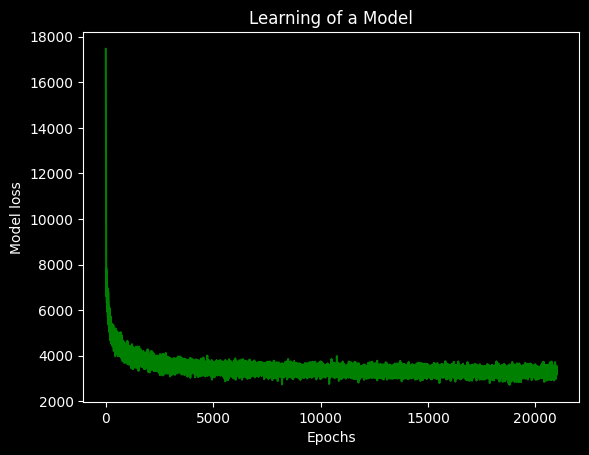

In [ ]:
plt.plot(losses, color = 'g', ls = '-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('Learning of a Model')
plt.show()

# Model Testing

In [ ]:
X = dataT[:7,:]  # Extracting first seven samples
model = model.cpu()
ypred, mu, logvar = model(X)

In [ ]:
ypred.shape

torch.Size([7, 784])

# Visualizing Model Performance

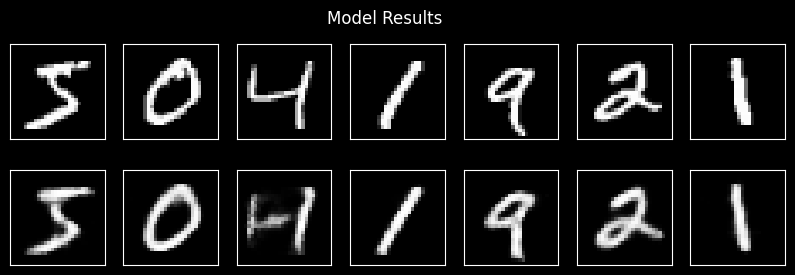

In [ ]:
fig,axes = plt.subplots(2,7,figsize=(10,3))

for i in range(7):
  axes[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axes[1,i].imshow(ypred[i,:].view(28,28).detach() ,cmap='gray')
  axes[0,i].set_xticks([]), axes[0,i].set_yticks([])
  axes[1,i].set_xticks([]), axes[1,i].set_yticks([])

plt.suptitle('Model Results')
plt.show()

## Generating 7 samples from Gaussian Distribution of size equal to latent layer size i.e 50

In [ ]:
sample = torch.randn(7,50)

# Pass the samples to decoder

In [ ]:
y_pred = model.decoder(sample)

# Visualize the decoder performance on randomly generated samples

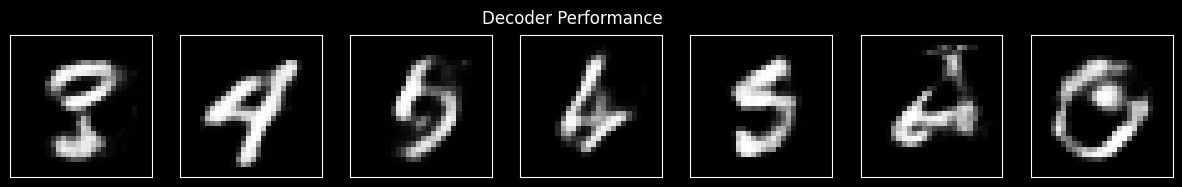

In [ ]:
fig,axes = plt.subplots(1,7,figsize=(15,2))

for i in range(7):
  axes[i].imshow(y_pred[i,:].view(28,28).detach() ,cmap='gray')
  axes[i].set_xticks([]), axes[i].set_yticks([])
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.suptitle('Decoder Performance')
plt.show()